<a href="https://colab.research.google.com/github/juhee3199/fake-news-detection/blob/main/feature%EC%B6%94%EA%B0%80%EB%AA%A8%EB%8D%B82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**EDA를 통한 변수 추가 모델**

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
path = "/gdrive/My Drive/Colab Notebooks/fake news detection"

train = pd.read_csv(path + "/news_train.csv")
test = pd.read_csv(path + "/news_test.csv")

In [4]:
# konlpy Mecab 사용하기

!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

+ pip install konlpy
     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 8.7MB/s 
     |████████████████████████████████| 460kB 48.3MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
+ bash -x
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_automake
+ '[' Linux == Linux ']'
++ grep -Ei 'debian|buntu|mint' /etc/lsb-

# content 맨앞이 [이거나 (이면 0

In [5]:
train["content_startswith_["]=train.content.apply(lambda x : str(x).startswith("[" ) or str(x).startswith("(") )+0

# 타이틀을 이용한 feature
- 해당 title에 몇가지 단어가 들어갈 경우 약 90% 이상이 info가 1

In [6]:
title_noise = ['적중 100%', '글로벌 주요 뉴스', '[전문가 의견]', 
               '[포커스]', '※','■', '▶' ,'◆','★',' TOP', 'BEST',
'전문가의 눈', '전문가선정', '전문가의견','】','후속주도 감사합니다',
               '전문가추천', '주요이슈']

def title_choose(x):
  if ("종목" in x["title"][-6:]) or ("관련주" in x["title"][-5:]):
    return 1
  elif (x["content"]=="코스피") or (x["content"]=="코스닥"):
    return 1
  for noise in title_noise:
    if noise in x["title"].upper():
      if (x["content"][:2]=="제목") or (x["content"][:1]=="["):
        return 0
      else:
        return 1
  return 0

In [7]:
train["info1_title"]=train.apply(title_choose, axis=1)

In [8]:
train[train['info1_title']==1]['info'].head()

92    1
93    1
94    1
95    1
96    1
Name: info, dtype: int64

# info가 1인 content에서 자주 등장하는 단어를 포함한 content를 1로하는 feature 추가

In [9]:
def in_bull(x):
    info_list = ['공개','추천','상한','무료','주식','바이오','금리','테마','탁론','카톡','실적',
                 '수익', '미수', '수혜주','급등', 'http', '하이스',"]]"]
    for i in info_list:
        if i in x:
            return 1
    return 0
train["info1_words"]=train["content"].apply(in_bull)

# Order을 이용한 feature

In [10]:
title_group = (train.groupby(["title"]).count())["n_id"]
train["new_ord"]=train.apply(lambda x: x["ord"]/title_group[x["title"]], axis=1)

# tokenization

In [11]:
train.head()

,n_id,date,title,content,ord,info,content_startswith_[,info1_title,info1_words,new_ord
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0,1,0,0,0.250000
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1,0,0,1,0.500000
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1,0,0,1,0.750000
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0,0,0,0,1.000000
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0,0,0,0,0.066667


In [12]:
from konlpy.tag import Mecab
import re
from konlpy.tag import Okt

def text_preprocessing(text_list):
    
    stopwords = [] #불용어 설정
    
    tokenizer = Mecab() #형태소 분석기 
    token_list = [] 
    
    for text in text_list:
        txt = re.sub('[^가-힣]', ' ', text) #한글만 남기고 다른 글자 모두 제거
        txt = re.sub('[가-힣\s]+기자]','기자', txt) #기자 이름 제거
        token = tokenizer.morphs(txt) #형태소 분석

        #형태소 분석 결과 중 stopwords에 해당하지 않고, float type이 아닌 것만 수집
        token = [t for t in token if t not in stopwords and type(t) != float] 
        token_list.append(token)
        
    return token_list, tokenizer

#형태소 분석기를 따로 저장한 이유는 후에 test 데이터 전처리를 진행할 때 이용해야 되기 때문입니다. 
train['new_article'], okt = text_preprocessing(train['content'])

In [13]:
# 결측치 제거
train = train[train["new_article"].apply(lambda x: False if len(x)==0 else True)]

# Vectorization

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 40

def text2sequence(train_text, max_len=100):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_text)
    train_X_seq = tokenizer.texts_to_sequences(train_text)
    vocab_size = len(tokenizer.word_index) + 1
    print('vocab_size : ', vocab_size)
    X_train = pad_sequences(train_X_seq, maxlen = max_len, truncating="post") # 길이를 맞춰줌
    return X_train, vocab_size, tokenizer

train_y = train['info']
train_X, vocab_size, vectorizer = text2sequence(train['new_article'], max_len = max_len)

print(train_X.shape, train_y.shape)

vocab_size :  33461
(118414, 40) (118414,)


## 3. Embedding

- 혜림 - 한국어 word2vec

In [ ]:
# import gensim
# from gensim.models.keyedvectors import KeyedVectors
# path = "/gdrive/My Drive/dacon_news"


# 한국어 word2vec model
# word2vec2 = gensim.models.Word2Vec.load(path+'/embedding/ko.bin')

embedding_matrix = np.zeros((vocab_size, 200))
vocab = vectorizer.word_index
count = 0

for idx, word in enumerate(vocab):
    if word in word2vec2:
      embedding_vector = word2vec2[word]
      embedding_matrix[idx] = embedding_vector
    else: # 임베딩 모델에 없는 것
      print(word, "word2vec에 없는 단어입니다.")
      count += 1
      pass

print('count: ', count)  

- 기존의 word2vec 사용

In [19]:
# word2vec

import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab Notebooks/fake news detection/GoogleNews-vectors-negative300.bin.gz', binary = True)

In [20]:
embedding_matrix = np.zeros((vocab_size, 300))
vocab = vectorizer.word_index
count = 0

for idx, word in enumerate(vocab):
    if word in word2vec:
      embedding_vector = word2vec[word]
      embedding_matrix[idx] = embedding_vector
    else: # 임베딩 모델에 없는 것
   #    print(word, "word2vec에 없는 단어입니다.")
      count += 1
      pass

print('count: ', count)  

count:  33427


#train test split

In [21]:
train_X = np.concatenate([train_X,train[["info1_title","new_ord","content_startswith_["]].values.reshape(-1,3)], axis=1)

In [22]:
# 문장별로 train_test set 분리
from sklearn.model_selection import train_test_split

#num_article = len(train["n_id"].unique())
#trainnp.random.randint(0,num_article,int(0.7*num_article))

X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, random_state = 42, test_size = 0.3)

In [23]:
index_seq = (X_train.argmax(axis=1)).argsort(axis=0)
X_train = X_train[index_seq]
y_train = y_train.iloc[index_seq]

In [24]:
X_train.shape


(82889, 43)

#모델링 비교

1. embedding vector만을 통한 모델링

In [28]:
# EDA기반으로 만든 feature 예측변수로 추가
from keras import regularizers


def LSTM_add_feature(vocab_size, embedding_size = 300, max_len=100):
  input1 = keras.layers.Input(shape = [max_len,]) #문장 단어 input
  input2 = keras.layers.Input(shape = [3,]) # EDA기반 feature input

  # LSTM
  embedding = keras.layers.Embedding(vocab_size, embedding_size, weights = [embedding_matrix], input_length = max_len)(input1) # 임베딩 가중치 적용
  dropout1 = keras.layers.SpatialDropout1D(0.5)(embedding)
  lstm1 = keras.layers.LSTM(32, return_sequences = True)(dropout1)
  lstm2 = keras.layers.LSTM(32)(lstm1)
  dropout2 = keras.layers.Dropout(0.5)(lstm2)
  #lstm_output = keras.layers.Dense(16, activation = "selu")(dropout2)

  # MLP
  concat = keras.layers.concatenate([dropout2,input2])
  hidden = keras.layers.Dense(16, activation = "selu")(concat)
  output = keras.layers.Dense(1, activation = "sigmoid")(hidden)

  model = keras.Model(inputs = [input1, input2], outputs = [output])

  model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), loss="binary_crossentropy", metrics = "accuracy")
  model.summary()
  return model


### validate

In [29]:
# 훈련 시
tf.random.set_seed(42)


checkpoint_cb = keras.callbacks.ModelCheckpoint("hyerim_add_feature_best_model2.h5",
                                               save_best_only = True)

# 하이퍼파라미터
max_epoch = 5
batch_size = 32
learning_rate = 0.001

model = LSTM_add_feature(vocab_size, max_len = max_len)
history = model.fit(x=[X_train[:,:-3],X_train[:,-3:]], y=y_train,epochs=max_epoch,
                batch_size = batch_size,  validation_data = ((X_valid[:,:-3],X_valid[:,-3:]),y_valid), validation_batch_size = batch_size,
                 callbacks = [checkpoint_cb])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 300)      10038300    input_5[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 40, 300)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 40, 32)       42624       spatial_dropout1d_2[0][0]        
____________________________________________________________________________________________

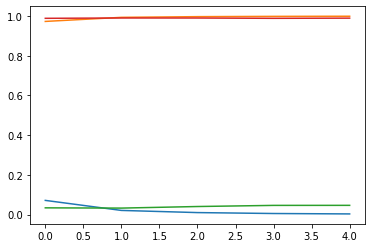

In [32]:
best_model = keras.models.load_model("hyerim_add_feature_best_model2.h5") # 저장된 모델 불러오기
plt.plot(pd.DataFrame(history.history))

In [33]:
# 성능

best_model.evaluate((X_valid[:,:-3],X_valid[:,-3:]),y_valid)

1111/1111 [==============================] - 14s 12ms/step - loss: 0.0327 - accuracy: 0.9902


[0.03271004930138588, 0.9902322292327881]

# 최종 훈련

In [ ]:
train_X.shape

(118414, 46)

In [ ]:
# 실제 예측시
index_seq = (train_X.argmax(axis=1)).argsort(axis=0)
train_X = train_X[index_seq]
train_y = train_y.iloc[index_seq]


tf.random.set_seed(42)

# 하이퍼파라미터
max_epoch = 5
batch_size = 32
learning_rate = 0.001

model = LSTM_add_feature(vocab_size, max_len = max_len)
history = model.fit(x=[train_X[:,:40],train_X[:,-3:]], y=train_y,epochs=max_epoch,batch_size = batch_size)  # -3 -> 40

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 40, 300)      10038300    input_19[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_7 (SpatialDro (None, 40, 300)      0           embedding_9[0][0]                
__________________________________________________________________________________________________
lstm_14 (LSTM)                  (None, 40, 32)       42624       spatial_dropout1d_7[0][0]        
____________________________________________________________________________________________

KeyboardInterrupt: ignored

# test 예측

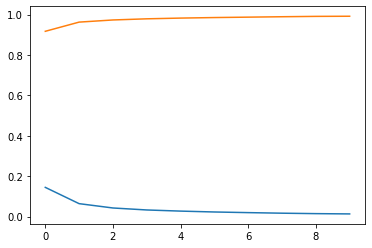

In [ ]:
plt.plot(pd.DataFrame(history.history))

In [ ]:
model.save('final_model.h5')

In [ ]:
test = pd.read_csv(path+"news_test.csv")

test["info1_title"]=test.apply(title_choose, axis=1)
#test["info1_words"]=test["content"].apply(in_bull)

test['new_article'], okt = text_preprocessing(test['content'])
test_X_seq = vectorizer.texts_to_sequences(test["new_article"])
test_X = pad_sequences(test_X_seq, maxlen = max_len) # 길이를 맞춰줌

test["content_startswith_["]=test.content.apply(lambda x : str(x).startswith("[" ) or str(x).startswith("(") )+0

title_group = (test.groupby(["title"]).count())["n_id"]
test["new_ord"]=test.apply(lambda x: x["ord"]/title_group[x["title"]], axis=1)

test_X = np.concatenate([test_X,test[["info1_title","new_ord","content_startswith_["]].values.reshape(-1,3)], axis=1)

In [ ]:
final_model = keras.models.load_model("final_model.h5") # 저장된 모델 불러오기
predicted = final_model.predict([test_X[:,:-3],test_X[:,-3:]])

In [ ]:
test["info"]=predicted
predicted[test["content"]=="종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지"]=0

In [ ]:
submission = pd.read_csv(path+"/data/sample_submission.csv")
submission["info"]=(test["info"]>=0.6)+0
submission.to_csv("hyerim_submission.csv", encoding="utf-8-sig",index=False)

In [ ]:
submission

,id,info
0,NEWS00237_1,0.0
1,NEWS00237_2,0.0
2,NEWS00237_3,0.0
3,NEWS00237_4,0.0
4,NEWS00237_5,0.0
...,...,...
142560,NEWS09482_72,1.0
142561,NEWS09482_73,1.0
142562,NEWS09482_74,1.0
142563,NEWS09482_75,1.0
